## Import Dependencies

In [1]:
# Install pytorch segmentation models
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a88e88494cf1592ab3bff924ee2690eb54fb288391640a6a4c6c5e547fe59d74
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=24c129fcea10e7342ef50a61e50dc798186f49cf4de7096f7428e4cab5baf17f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import segmentation_models_pytorch as smp # UNet

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [4]:
# Read in the dataset
df = pd.read_csv("/kaggle/input/roads-segmentation-dataset/roads_segmentation.csv")
df.head()

,image_id,image_name
0,0,images/0.png
1,1,images/1.png
2,2,images/2.png
3,3,images/3.png
4,4,images/4.png


In [5]:
IMAGES_DIR = "/kaggle/input/roads-segmentation-dataset/images"
MASKS_DIR = "/kaggle/input/roads-segmentation-dataset/masks"

## Initial Visualization

In [6]:
def visualize_data(images_data:pd.DataFrame, num_imgs:int = 4, images_dir:str = IMAGES_DIR, 
                   masks_dir:str = MASKS_DIR):
    """
    Takes in the dataframe from 'road_segmentation.csv' and visualizes random images and their corresponding masks
    """
    row_samples = images_data.sample(num_imgs) # Get image paths
    fig = plt.figure(figsize = (10,10))
    
    k = 0 # Index for subplot
    for _, row in row_samples.iterrows():
        image_name = row["image_name"].split("/")[1]
        img_path = os.path.join(images_dir, image_name) # Get image path
        mask_path = os.path.join(masks_dir, image_name) # Get corresponding mask path
        
        # Plot the images
        ax = fig.add_subplot(num_imgs, 2, k + 1)
        img = plt.imread(img_path)
        ax.imshow(img) # View Image
        
        ax = fig.add_subplot(num_imgs, 2, k + 2)
        mask = plt.imread(mask_path)
        ax.imshow(mask) # View Mask
        
        k += 2
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_data(images_data = df)

## Preprocessing

In [ ]:
# Include column in the dataframe for the mask and image paths
df["image_path"] = df["image_name"].str.replace("images", IMAGES_DIR)
df["mask_path"] = df["image_name"].str.replace("images", MASKS_DIR)
df.head()

In [ ]:
# Dictionary to map the color to a class label
# Note: Taken from another notebook
color2id = {(184, 61, 245): 0, # #b83df5: backgroud
            (255, 53, 94):1, # #ff355e: road_sign
            (255, 204, 51):2, # #ffcc33: car
            (221, 255, 51):3, # #ddff33: marking
            (61,61, 245):4} # #3d3df5: road_surface

In [ ]:
def mapping_color(img:Image, color2id:dict):
    
    """
    Takes an image/mask and creates the image with the class labels to be used for the loss function
    """
    
    image = np.array(img)
    
    height,width,_ = image.shape
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32)
    
    for h in range(height):
        for w in range(width):
            color_pixel = tuple(image[h,w,:])
            
            if color_pixel in color2id:
                output_matrix[h,w] = color2id[color_pixel]
            
    
    return output_matrix

## Dataset

In [ ]:
# Create Custom Dataset
class RoadSegmentationDataset(Dataset):
    def __init__(self, images_data:pd.DataFrame, color2id:dict, image_transforms = None, mask_transforms = None):
        self.images_data = images_data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.images_data)
    
    def __getitem__(self, idx):
        image_path = self.images_data.iloc[idx]["image_path"]
        mask_path = self.images_data.iloc[idx]["mask_path"]
        
        img = Image.open(image_path).convert("RGB")
        if self.image_transforms:
            img = self.image_transforms(img)
            
        mask = Image.open(mask_path).convert("RGB")
        if self.mask_transforms:
            mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)
            
        return img, mask

In [ ]:
# Transforms
image_transforms = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.Resize((512,512))
])

In [ ]:
# Create Custom Dataset
dataset = RoadSegmentationDataset(df, color2id, image_transforms, mask_transforms)

In [ ]:
# Split the dataset into training, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.70, 0.15, 0.15])

In [ ]:
# Create the training, validation, and test dataloader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

## Segmentation Model

### UNet

In [16]:
# Initialize the UNet Model
model = smp.Unet(classes = 5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 197MB/s] 


In [17]:
# Freeze the encoder layer
for layer in model.encoder.parameters():
    layer.requires_grad = False

### Loss Function and Optimizer

In [18]:
# Loss function and Optimizer
criterion = smp.losses.DiceLoss(mode = "multiclass", classes = 5, ignore_index = -1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", 
                                                       factor = 0.1, patience = 5, 
                                                       verbose = True)
scaler = torch.cuda.amp.GradScaler() # Mixed Precision

### Callbacks

In [19]:
# Early Stopping Callback
class EarlyStoppingCallback:
    def __init__(self, patience = 5, metric_name = "validation_loss"):
        self.patience = patience
        self.metric_name = metric_name
        self.best_metric_value = float("inf")
        self.counter = 0
    
    def __call__(self, current_metric_value):
        improvement = current_metric_value < self.best_metric_value
        
        if improvement:
            self.best_metric_value = current_metric_value
            self.counter = 0
        else:
            self.counter += 1
            
        return self.counter >= self.patience

In [20]:
# Model Checkpoint Callback
class ModelCheckpointCallback:
    def __init__(self, save_path = "best_runs", save_best_only=True, metric_name='validation_loss'):
        self.save_path = save_path
        self.save_best_only = save_best_only
        self.metric_name = metric_name
        self.best_metric_value = float('inf') 
        
        if not os.path.exists(save_path):
            os.makedirs(f"{save_path}")
            print(f"Creating Directory {save_path}")
        else:
            print("Directory already exists")

    def __call__(self, model, current_metric_value, epoch):
        if self.save_best_only:
            improvement = current_metric_value < self.best_metric_value
        else:
            improvement = True

        if improvement:
            self.best_metric_value = current_metric_value

            # Save the entire model state
            checkpoint_path = os.path.join(self.save_path, f'best_model.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model checkpoint saved at: {checkpoint_path}')

### Train Step

In [21]:
def train_step(model:nn.Module, criterion:nn.Module, train_dataloader:DataLoader, 
               val_dataloader:DataLoader, optimizer:torch.optim.Optimizer, 
               scaler: torch.cuda.amp.GradScaler, early_stopping, model_checkpoint, epochs:int = 10):
    """
    Trains the model on the train_dataloader and evaluates on the val_dataloader and returns the losses and metrics
    """
    train_losses = []
    train_ious = []
    val_losses = []
    val_ious = []
    
    
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        
        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (X,y) in loop:
            X, y = X.to(device, dtype = torch.float32), y.to(device, dtype = torch.long) # Load data into GPU
            
            with torch.cuda.amp.autocast():
                y_logit = model(X) # Make prediction

                loss = criterion(y_logit, y) # Calculate the loss
                train_loss += loss.item()
            
            y_prob = y_logit.softmax(dim = 1)
            pred_class = y_prob.argmax(dim = 1)
            
            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(), 
                                            target = y.cpu(), 
                                            mode = "multiclass", 
                                            ignore_index = -1, 
                                            num_classes = 5)
            
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
            train_iou += iou.item()
            
            optimizer.zero_grad() # Zero Gradients
            scaler.scale(loss).backward() # Backpropagation
            scaler.step(optimizer) # Gradient Descent
            scaler.update()
            
            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss = loss.item(), iou = iou.item())
            
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        train_iou /= len(train_dataloader)
        train_ious.append(train_iou)
        
        # Validation Step
        model.eval()
        val_loss = 0
        val_iou = 0
        with torch.inference_mode():
            val_loop = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave = False)
            for batch, (X,y) in val_loop:
                X, y = X.to(device, dtype = torch.float32), y.to(device, dtype = torch.long) # Load data into GPU
                
                with torch.cuda.amp.autocast():
                    y_logit = model(X) # Make prediction

                    loss = criterion(y_logit, y) # Calculate the loss
                    val_loss += loss.item()
                
                y_prob = y_logit.softmax(dim = 1)
                pred_class = y_prob.argmax(dim = 1)
                
                tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(), 
                                            target = y.cpu(), 
                                            mode = "multiclass", 
                                            ignore_index = -1, 
                                            num_classes = 5)
                
                iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
                val_iou += iou.item()
                
                # Update Progress Bar
                val_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                val_loop.set_postfix(loss = loss.item(), iou = iou.item())
                
            val_loss = val_loss / len(val_dataloader)
            val_losses.append(val_loss)
            val_iou = val_iou / len(val_dataloader)
            val_ious.append(val_iou)
            
        print(f'Epoch: {epoch + 1} | ', 
          f'Train Loss: {train_loss:.4f} | ', 
          f'Train IOU: {train_iou:.4f} | ', 
          f'Val Loss: {val_loss:.4f} | ', 
          f'Val IOU: {val_iou:.4f}')

        # Model Checkpoint Callback
        model_checkpoint(model, val_loss, epoch)

        # Early Stopping Callback
        if early_stopping(val_loss):
            print("Early Stopping")
            break
        
        scheduler.step(val_loss) # Reduce Learning Rate
        
    return {
        "train_loss" : train_losses,
        "train_iou": train_ious,
        "val_loss" : val_losses,
        "val_iou" : val_ious
    }

In [22]:
# Train the model
torch.cuda.manual_seed(42)
torch.manual_seed(42)


early_stopping = EarlyStoppingCallback(patience=15, metric_name='validation_loss')
model_checkpoint = ModelCheckpointCallback()
model = model.to(device)
                  
history = train_step(model, criterion, train_dataloader, 
                     val_dataloader, optimizer, scaler, 
                     early_stopping, model_checkpoint, epochs = 100)

Creating Directory best_runs


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.5238 |  Train IOU: 0.7903 |  Val Loss: 0.5811 |  Val IOU: 0.6918
Model checkpoint saved at: best_runs/best_model.pth


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.3917 |  Train IOU: 0.9212 |  Val Loss: 0.4373 |  Val IOU: 0.9464
Model checkpoint saved at: best_runs/best_model.pth


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.3639 |  Train IOU: 0.9513 |  Val Loss: 0.4059 |  Val IOU: 0.9646
Model checkpoint saved at: best_runs/best_model.pth


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.3476 |  Train IOU: 0.9516 |  Val Loss: 0.3811 |  Val IOU: 0.9738
Model checkpoint saved at: best_runs/best_model.pth


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2938 |  Train IOU: 0.9598 |  Val Loss: 0.4766 |  Val IOU: 0.9581


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.5119 |  Train IOU: 0.9075 |  Val Loss: 0.5569 |  Val IOU: 0.6474


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.4927 |  Train IOU: 0.8915 |  Val Loss: 0.5095 |  Val IOU: 0.9501


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.4777 |  Train IOU: 0.9124 |  Val Loss: 0.5084 |  Val IOU: 0.9333


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.4482 |  Train IOU: 0.9292 |  Val Loss: 0.4942 |  Val IOU: 0.9322


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.4570 |  Train IOU: 0.9167 |  Val Loss: 0.4839 |  Val IOU: 0.9516
Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.4326 |  Train IOU: 0.9236 |  Val Loss: 0.4722 |  Val IOU: 0.9564


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.4193 |  Train IOU: 0.9302 |  Val Loss: 0.4714 |  Val IOU: 0.9559


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.4124 |  Train IOU: 0.9317 |  Val Loss: 0.4756 |  Val IOU: 0.9529


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.4088 |  Train IOU: 0.9345 |  Val Loss: 0.4724 |  Val IOU: 0.9566


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.4031 |  Train IOU: 0.9372 |  Val Loss: 0.4720 |  Val IOU: 0.9560


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.4006 |  Train IOU: 0.9396 |  Val Loss: 0.4740 |  Val IOU: 0.9543
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.3985 |  Train IOU: 0.9407 |  Val Loss: 0.4723 |  Val IOU: 0.9546


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.3982 |  Train IOU: 0.9409 |  Val Loss: 0.4678 |  Val IOU: 0.9550


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.3979 |  Train IOU: 0.9411 |  Val Loss: 0.4715 |  Val IOU: 0.9553
Early Stopping


## Model Evaluation

### Visualization

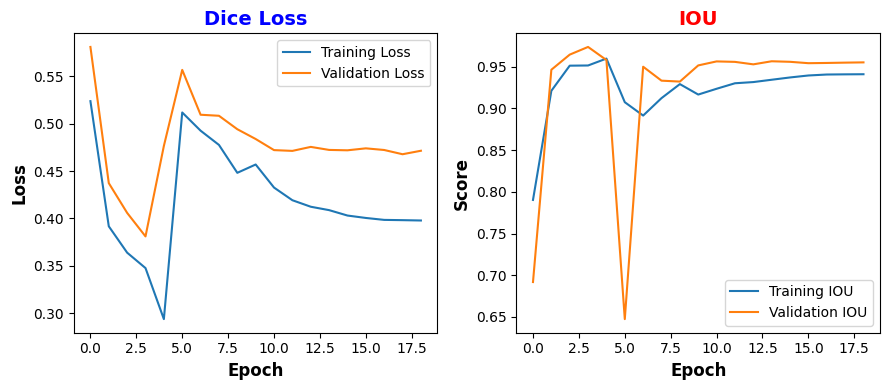

In [35]:
# Plot the loss and IOU metrics
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
axes[0].plot(history["train_loss"], label = "Training Loss")
axes[0].plot(history["val_loss"], label = "Validation Loss")
axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
axes[0].set_title("Dice Loss", fontsize = 14, fontweight = "bold", color = "blue")
axes[0].legend()

axes[1].plot(history["train_iou"], label = "Training IOU")
axes[1].plot(history["val_iou"], label = "Validation IOU")
axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
axes[1].set_ylabel("Score", fontsize = 12, fontweight = "bold", color = "black")
axes[1].set_title("IOU", fontsize = 14, fontweight = "bold", color = "red")
axes[1].legend()

fig.tight_layout()
fig.show()


### Model Prediction

In [24]:
# Get the best model
model = smp.Unet(classes = 5)
model.load_state_dict(torch.load("/kaggle/working/best_runs/best_model.pth"))

<All keys matched successfully>

In [25]:
# View Test Predictions
def predict(test_dataloader:DataLoader, model:nn.Module):
    """
    Takes in the model and makes masks predictions on the test_dataloader
    """
    model.to(device)
    model.eval()
    pred_masks = []
    
    with torch.inference_mode():
        for X, _ in tqdm(test_dataloader, total = len(test_dataloader)):
            X = X.to(device, dtype = torch.float32)
            pred_logit = model(X)
            prob_mask = pred_logit.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            pred_masks.append(pred_mask.detach().cpu())
    
    pred_masks = torch.cat(pred_masks)
    return pred_masks

In [26]:
# Make predictions and get the test IOU
pred_masks = predict(test_dataloader, model)

  0%|          | 0/4 [00:00<?, ?it/s]

### Test IOU

In [27]:
# Create tensors of the test images and masks to compare and visualize
images_test = []
masks_test = []

for img, mask in test_dataloader:
    images_test.append(img)
    masks_test.append(mask)

images_test = torch.cat(images_test)
masks_test = torch.cat(masks_test)

In [28]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_masks.long(), 
                                       target = masks_test.long(), 
                                       mode = "multiclass", 
                                       ignore_index = -1, 
                                       num_classes = 5)

In [29]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9818


### Mask Visualization

In [30]:
id2color = dict((v,k) for k,v in color2id.items())

In [31]:
# Map the label of each pixel to the appropriate color
filled_pred_masks = []

for test_mask, pred_mask in zip(masks_test, pred_masks):
    height, width = pred_mask.shape
    ignore = test_mask == -1
    
    pred_mask = torch.where(ignore, -1, pred_mask)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(pred_mask[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    filled_pred_masks.append(mask_zeros)

In [32]:
# Map the test masks with the colors
filled_test_masks = []

for test_mask in masks_test:
    
    height, width = test_mask.shape
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(test_mask[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    filled_test_masks.append(mask_zeros)

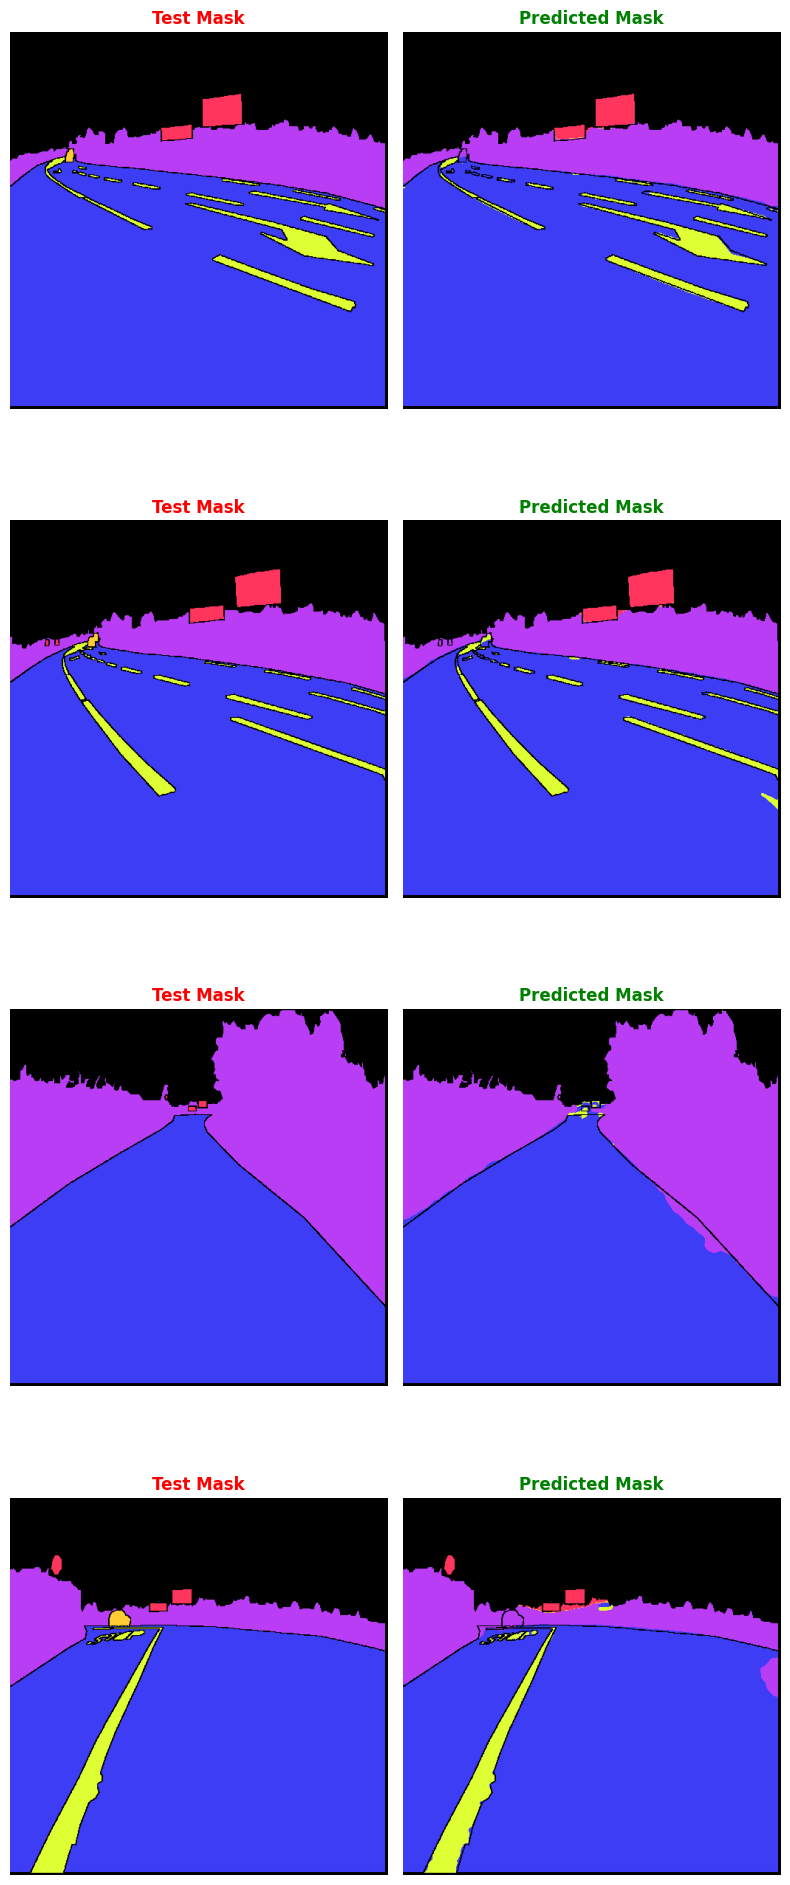

In [33]:
# Visualize predicted masks and test masks
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (8,20))

for i, (pred_mask, test_mask) in enumerate(zip(filled_pred_masks, filled_test_masks)):
    
    test_mask = test_mask.numpy()
    axes[i,0].imshow(test_mask)
    axes[i,0].set_title("Test Mask", fontsize = 12, fontweight = "bold", color = "red")
    axes[i,0].axis('off')
    
    pred_mask = pred_mask.numpy()
    axes[i,1].imshow(pred_mask)
    axes[i,1].set_title("Predicted Mask", fontsize = 12, fontweight = "bold", color = "green")
    axes[i,1].axis('off')
    
fig.tight_layout()
fig.show()